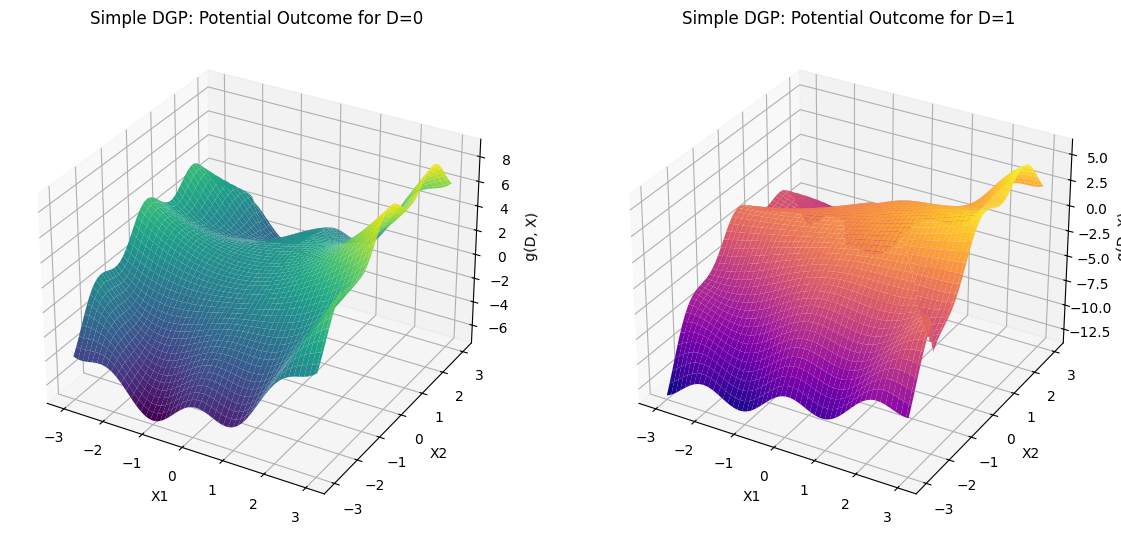

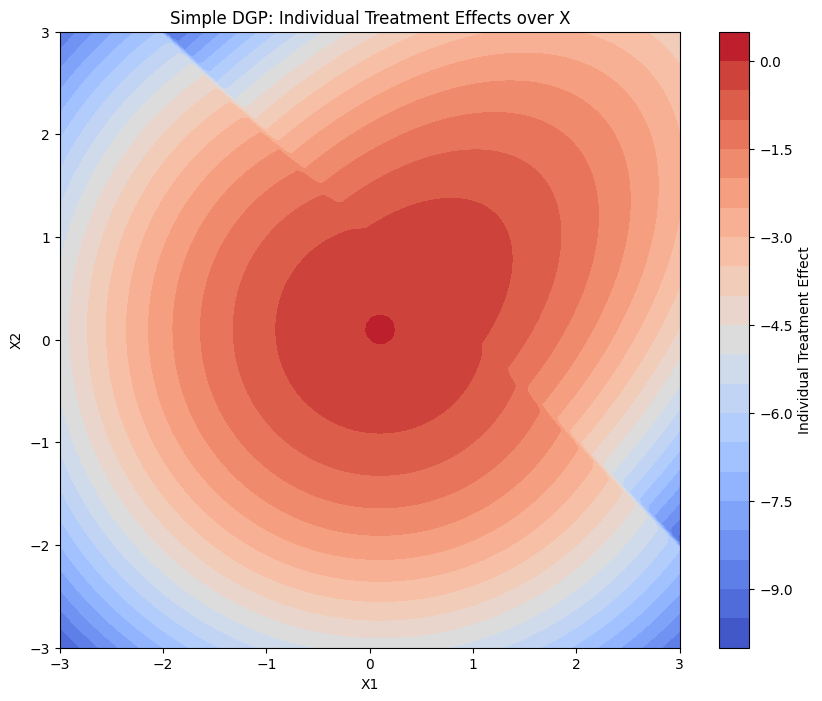

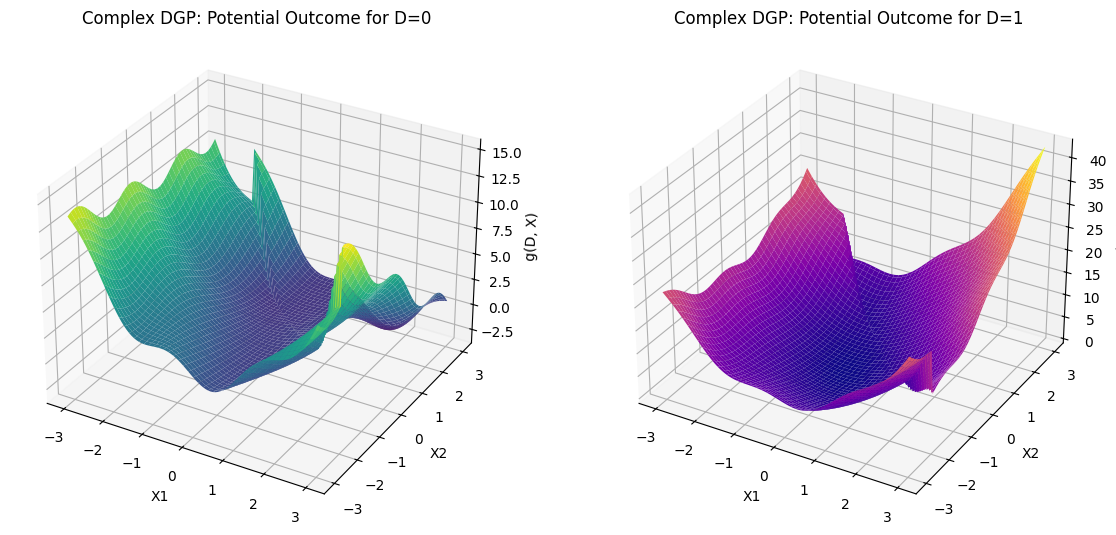

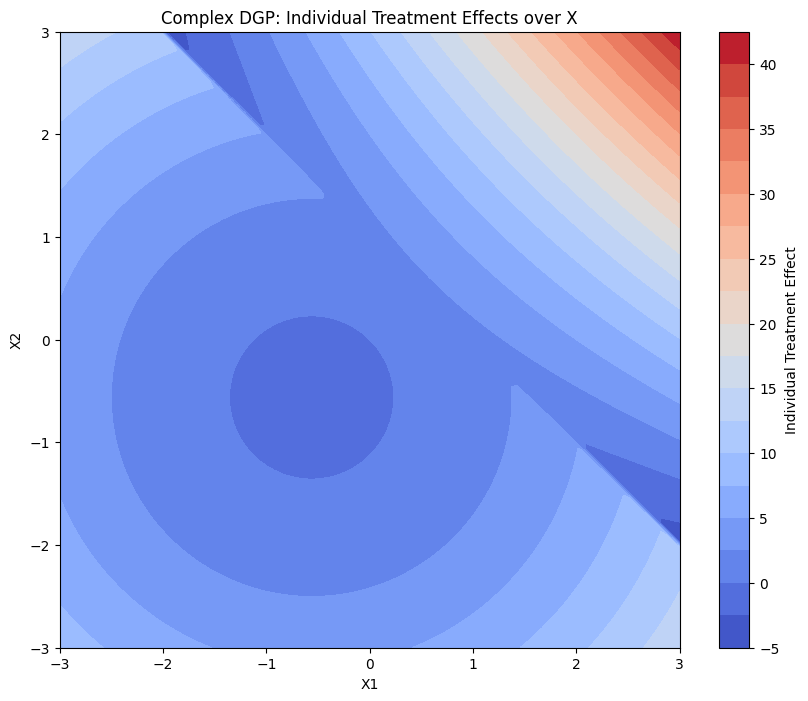

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def DGP_simple(D, X):
    linear_terms = np.sum(X, axis=1)
    interaction_terms = np.prod(X, axis=1)
    squared_terms = np.sum(X**2, axis=1)
    stepwise_terms = np.where(linear_terms > X.shape[1]/2, 1, 0) * interaction_terms
    interactive = D * (0.1 * linear_terms + -0.5 * squared_terms + 0.5 * stepwise_terms)
    non_interactive = 0.8 * linear_terms + -0.4 * squared_terms + 0.05 * stepwise_terms
    return interactive + non_interactive + np.cos(interaction_terms) + X[:, 0]**2

def DGP_complex(D, X):
    linear_terms = np.sum(X, axis=1)
    interaction_terms = np.prod(X, axis=1)
    squared_terms = np.sum(X**2, axis=1)
    stepwise_terms = np.where(linear_terms > X.shape[1]/2, 1, 0) * interaction_terms
    weights_linear_int = D * 0.1 + (1 - D) * 0.2
    weights_squared_int = D * 0.5 + (1 - D) * 0.3
    weights_stepwise_int = D * 0.9 + (1 - D) * -0.1
    weights_linear_nonint = D * 0.4 + (1 - D) * -0.6
    weights_squared_nonint = D * 0.4 + (1 - D) * -0.2
    weights_stepwise_nonint = D * 0.7 + (1 - D) * -0.8
    interactive = weights_linear_int * linear_terms + weights_squared_int * squared_terms + weights_stepwise_int * stepwise_terms
    non_interactive = weights_linear_nonint * linear_terms + weights_squared_nonint * squared_terms + weights_stepwise_nonint * stepwise_terms
    return interactive + non_interactive + np.sin(interaction_terms) + X[:, 0]**2

def plot_dgp_results(X1, X2, Y_D0, Y_D1, individual_effects, dgp_name):
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X1, X2, Y_D0, cmap='viridis')
    ax1.set_title(f'{dgp_name}: Potential Outcome for D=0')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('g(D, X)')
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X1, X2, Y_D1, cmap='plasma')
    ax2.set_title(f'{dgp_name}: Potential Outcome for D=1')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('g(D, X)')
    plt.show()
    plt.figure(figsize=(10, 8))
    plt.contourf(X1, X2, individual_effects, cmap='coolwarm', levels=20)
    plt.colorbar(label='Individual Treatment Effect')
    plt.title(f'{dgp_name}: Individual Treatment Effects over X')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

Y_D0_simple = DGP_simple(0, X_grid).reshape(X1.shape)
Y_D1_simple = DGP_simple(1, X_grid).reshape(X1.shape)
individual_effects_simple = Y_D1_simple - Y_D0_simple
plot_dgp_results(X1, X2, Y_D0_simple, Y_D1_simple, individual_effects_simple, 'Simple DGP')

Y_D0_complex = DGP_complex(0, X_grid).reshape(X1.shape)
Y_D1_complex = DGP_complex(1, X_grid).reshape(X1.shape)
individual_effects_complex = Y_D1_complex - Y_D0_complex
plot_dgp_results(X1, X2, Y_D0_complex, Y_D1_complex, individual_effects_complex, 'Complex DGP')

In [7]:
import numpy as np

# Function to calculate true ATE by averaging the differences between potential outcomes
def calculate_true_ate(N=10000, K=2, DGP_func=None, **kwargs):
    X = np.random.normal(0, 1, (N, K))
    Y_0 = DGP_func(0, X, **kwargs)
    Y_1 = DGP_func(1, X, **kwargs)
    true_ate = np.mean(Y_1 - Y_0)
    return true_ate

def calculate_true_ate_for_all(N=10000, K=2):
    true_ate_simple = np.mean([calculate_true_ate(N=N, K=K, DGP_func=DGP_simple) for i in range(2000)])
    true_ate_complex = np.mean([calculate_true_ate(N=N, K=K, DGP_func=DGP_complex) for i in range(2000)])
    print(f"True ATE for Simple DGP: {true_ate_simple}")
    print(f"True ATE for Complex DGP: {true_ate_complex}")
    return true_ate_simple, true_ate_complex

# Example usage with specific parameters
true_ate_simple, true_ate_complex = calculate_true_ate_for_all(N=10000, K=2)

True ATE for Simple DGP: -0.9449536219984666
True ATE for Complex DGP: 1.873875733043004


In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import KFold

def bivariate_ols(Y, W):
    return LinearRegression().fit(W.reshape(-1, 1), Y).coef_[0]
    
def multivariate_ols(X, Y, W):
    return LinearRegression().fit(np.column_stack((W, X)), Y).coef_[0]
    
def interaction_ols(X, Y, W):
    return LinearRegression().fit(np.column_stack((W, X, W[:, np.newaxis] * (X - X.mean(axis=0)))), Y).coef_[0]

def s_learner(X, Y, W, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mu1, mu0 = np.zeros(len(Y)), np.zeros(len(Y))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        W_train, Y_train = W[train_index], Y[train_index]
        model_s = lgb.LGBMRegressor(verbose=-1)
        model_s.fit(np.column_stack((W_train, X_train)), Y_train)
        mu1[test_index] = model_s.predict(np.column_stack((np.ones(len(X_test)), X_test)))
        mu0[test_index] = model_s.predict(np.column_stack((np.zeros(len(X_test)), X_test)))
    return np.mean(mu1 - mu0)

def t_learner(X, Y, W, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mu1, mu0 = np.zeros(len(Y)), np.zeros(len(Y))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        W_train, Y_train = W[train_index], Y[train_index]
        model_mu1 = lgb.LGBMRegressor(verbose=-1)
        model_mu0 = lgb.LGBMRegressor(verbose=-1)
        model_mu1.fit(X_train[W_train == 1], Y_train[W_train == 1])
        model_mu0.fit(X_train[W_train == 0], Y_train[W_train == 0])
        mu1[test_index] = model_mu1.predict(X_test)
        mu0[test_index] = model_mu0.predict(X_test)
    return np.mean(mu1 - mu0)

def x_learner(X,Y,W,n_splits=5):
    kf=KFold(n_splits=n_splits,shuffle=True,random_state=42)
    cate_treated=np.zeros(len(Y))
    cate_control=np.zeros(len(Y))
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index],X[test_index]
        Y_train,W_train=Y[train_index],W[train_index]
        model_mu1=lgb.LGBMRegressor(verbose=-1)
        model_mu0=lgb.LGBMRegressor(verbose=-1)
        model_mu1.fit(X_train[W_train==1],Y_train[W_train==1])
        model_mu0.fit(X_train[W_train==0],Y_train[W_train==0])
        mu1,mu0=model_mu1.predict(X_test),model_mu0.predict(X_test)
        cate_treated[test_index[W[test_index]==1]]=Y[test_index[W[test_index]==1]]-mu0[W[test_index]==1]
        cate_control[test_index[W[test_index]==0]]=mu1[W[test_index]==0]-Y[test_index[W[test_index]==0]]
    final_cate_estimates=np.zeros(len(Y))
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index],X[test_index]
        model_tau_treated=lgb.LGBMRegressor(reg_alpha=0,verbose=-1)
        model_tau_control=lgb.LGBMRegressor(reg_alpha=0,verbose=-1)
        model_tau_treated.fit(X_train[W[train_index]==1],cate_treated[train_index[W[train_index]==1]])
        model_tau_control.fit(X_train[W[train_index]==0],cate_control[train_index[W[train_index]==0]])
        tau_treated,tau_control=model_tau_treated.predict(X_test),model_tau_control.predict(X_test)
        g=np.mean(W)
        final_cate_estimates[test_index]=g*tau_treated+(1-g)*tau_control
    return np.mean(final_cate_estimates)

def r_learner(X, Y, W, M_y=lgb.LGBMRegressor(), M_T=lgb.LGBMRegressor(), n_splits=5):
    y_residuals, T_residuals = np.zeros(len(Y)), np.zeros(len(W))
    for train_idx, test_idx in KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        M_y.fit(X_train, Y[train_idx])
        M_T.fit(X_train, W[train_idx])
        y_residuals[test_idx] = Y[test_idx] - M_y.predict(X_test)
        T_residuals[test_idx] = W[test_idx] - M_T.predict(X_test)
    return LinearRegression().fit(T_residuals.reshape(-1, 1), y_residuals).coef_[0]

def i_learner(X,Y,W,n_splits=5):
    kf=KFold(n_splits=n_splits,shuffle=True,random_state=42)
    Y_hat=np.zeros(len(Y))
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index],X[test_index]
        Y_train=Y[train_index]
        model_lgbm=lgb.LGBMRegressor(verbose=-1).fit(X_train,Y_train)
        Y_hat[test_index]=model_lgbm.predict(X_test)
    interaction_term=W*(Y_hat-np.mean(Y_hat))
    return LinearRegression().fit(np.column_stack((W,Y_hat,interaction_term)),Y).coef_[0]

def dr_learner(X, Y, W, p=0.3, n_splits=5):
    mu1, mu0 = np.zeros(len(Y)), np.zeros(len(Y))
    for train_index, test_index in KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X):
        X_train, X_test = X[train_index], X[test_index]
        W_train, Y_train = W[train_index], Y[train_index]
        model_mu1 = lgb.LGBMRegressor(verbose=-1)
        model_mu0 = lgb.LGBMRegressor(verbose=-1)
        model_mu1.fit(X_train[W_train == 1], Y_train[W_train == 1])
        model_mu0.fit(X_train[W_train == 0], Y_train[W_train == 0])
        mu1[test_index], mu0[test_index] = model_mu1.predict(X_test), model_mu0.predict(X_test)
    return np.mean(W * (Y - mu1) / p - (1 - W) * (Y - mu0) / (1 - p) + mu1 - mu0)

import numpy as np

# Assuming the required functions (bivariate_ols, multivariate_ols, etc.) and DGPs (DGP_simple, DGP_complex) are defined above
def generate_data_simple(N=100, p=0.3, K=2, DGP_func=None, q=1.0):
    X = np.random.normal(0, 1, (N, K))
    W = np.random.binomial(1, p, N)
    Y = DGP_func(W, X) + np.random.normal(scale=q, size=N)
    return Y, W, X
    
# Generate data and run models for DGP 1 (Simple DGP)
Y, W, X = generate_data_simple(N=10000, p=0.3, K=2, DGP_func=DGP_simple, q=1.0)

# Run the learners
bivariate_ols_estimate_1 = bivariate_ols(Y, W)
multivariate_ols_estimate_1 = multivariate_ols(X, Y, W)
interaction_ols_estimate_1 = interaction_ols(X, Y, W)
s_learner_estimate_1 = s_learner(X, Y, W)
t_learner_estimate_1 = t_learner(X, Y, W)
x_learner_estimate_1 = x_learner(X, Y, W)
r_learner_estimate_1 = r_learner(X, Y, W)
i_learner_estimate_1 = i_learner(X, Y, W)
dr_estimate_1 = dr_learner(X, Y, W)

# Print results for DGP 1 (Simple DGP)
print("\nDGP 1 (Simple DGP) Results:")
print(f"B-OLS: {bivariate_ols_estimate_1}")
print(f"M-OLS: {multivariate_ols_estimate_1}")
print(f"I-OLS: {interaction_ols_estimate_1}")
print(f"S-Learner: {s_learner_estimate_1}")
print(f"T-Learner: {t_learner_estimate_1}")
print(f"X-Learner: {x_learner_estimate_1}")
print(f"R-Learner: {r_learner_estimate_1}")
print(f"I-Learner: {i_learner_estimate_1}")
print(f"DR-Learner: {dr_estimate_1}")

# Generate data and run models for DGP 2 (Complex DGP)
Y, W, X = generate_data_simple(N=10000, p=0.3, K=2, DGP_func=DGP_complex, q=1.0)

# Run the learners
bivariate_ols_estimate_2 = bivariate_ols(Y, W)
multivariate_ols_estimate_2 = multivariate_ols(X, Y, W)
interaction_ols_estimate_2 = interaction_ols(X, Y, W)
s_learner_estimate_2 = s_learner(X, Y, W)
t_learner_estimate_2 = t_learner(X, Y, W)
x_learner_estimate_2 = x_learner(X, Y, W)
r_learner_estimate_2 = r_learner(X, Y, W)
i_learner_estimate_2 = i_learner(X, Y, W)
dr_estimate_2 = dr_learner(X, Y, W)

# Print results for DGP 2 (Complex DGP)
print("\nDGP 2 (Complex DGP) Results:")
print(f"B-OLS: {bivariate_ols_estimate_2}")
print(f"M-OLS: {multivariate_ols_estimate_2}")
print(f"I-OLS: {interaction_ols_estimate_2}")
print(f"S-Learner: {s_learner_estimate_2}")
print(f"T-Learner: {t_learner_estimate_2}")
print(f"X-Learner: {x_learner_estimate_2}")
print(f"R-Learner: {r_learner_estimate_2}")
print(f"I-Learner: {i_learner_estimate_2}")
print(f"DR-Learner: {dr_estimate_2}")


DGP 1 (Simple DGP) Results:
B-OLS: -0.9607516800003824
M-OLS: -0.9405178997818981
I-OLS: -0.9393020653064216
S-Learner: -0.9212828490037654
T-Learner: -0.9370455856142291
X-Learner: -0.9376075440939385
R-Learner: -0.9682994017981901
I-Learner: -0.9495427007053883
DR-Learner: -0.9458118514964077

DGP 2 (Complex DGP) Results:
B-OLS: 1.7869689449629633
M-OLS: 1.780125019302735
I-OLS: 1.8000026194033554
S-Learner: 1.800745120732724
T-Learner: 1.8127429457801347
X-Learner: 1.8114518446656738
R-Learner: 1.828338325181798
I-Learner: 1.7876953957455008
DR-Learner: 1.8236764099029554


In [9]:
import numpy as np
import pandas as pd
from timeit import timeit

# Helper function to run and time each learner
def run_and_time_learners(Y, W, X, n_samples=7):
    learners = {
        "B-OLS": lambda: bivariate_ols(Y, W),
        "M-OLS": lambda: multivariate_ols(X, Y, W),
        "I-OLS": lambda: interaction_ols(X, Y, W),
        "S-Learner": lambda: s_learner(X, Y, W),
        "T-Learner": lambda: t_learner(X, Y, W),
        "X-Learner": lambda: x_learner(X, Y, W),
        "R-Learner": lambda: r_learner(X, Y, W),
        "I-Learner": lambda: i_learner(X, Y, W),
        "DR-Learner": lambda: dr_learner(X, Y, W)
    }
    times = {learner: np.mean([timeit(learners[learner], number=1) for _ in range(n_samples)]) for learner in learners}
    b_ols_time = times["B-OLS"]
    time_comparison = {learner: time / b_ols_time for learner, time in times.items()}
    return times, time_comparison

# Generate data for Simple DGP
Y_simple, W_simple, X_simple = generate_data_simple(N=10000, p=0.3, K=2, DGP_func=DGP_simple, q=1.0)
times_simple, comparison_simple = run_and_time_learners(Y_simple, W_simple, X_simple)

# Generate data for Complex DGP
Y_complex, W_complex, X_complex = generate_data_simple(N=10000, p=0.3, K=2, DGP_func=DGP_complex, q=1.0)
times_complex, comparison_complex = run_and_time_learners(Y_complex, W_complex, X_complex)

# Combine both into one DataFrame
combined_times = pd.DataFrame({
    'DGP Simple (Seconds)': {k: f"{v:.4f}s" for k, v in times_simple.items()},
    'DGP Simple (Inc)': {k: f"{v:.2f}x" for k, v in comparison_simple.items()},
    'DGP Complex (Seconds)': {k: f"{v:.4f}s" for k, v in times_complex.items()},
    'DGP Complex (Inc)': {k: f"{v:.2f}x" for k, v in comparison_complex.items()},
})

print("Time Increase and Absolute Time Comparison:")
display(combined_times)

Time Increase and Absolute Time Comparison:


DGP Simple (Seconds) DGP Simple (Inc) DGP Complex (Seconds)  \
B-OLS                   0.0008s            1.00x               0.0008s   
M-OLS                   0.0013s            1.68x               0.0013s   
I-OLS                   0.0019s            2.46x               0.0018s   
S-Learner               0.4134s          536.38x               0.4105s   
T-Learner               0.6905s          896.01x               0.6920s   
X-Learner               1.3666s         1773.39x               1.3840s   
R-Learner               0.7115s          923.28x               0.7120s   
I-Learner               0.3715s          482.08x               0.3699s   
DR-Learner              0.6918s          897.66x               0.6865s   

           DGP Complex (Inc)  
B-OLS                  1.00x  
M-OLS                  1.58x  
I-OLS                  2.22x  
S-Learner            499.82x  
T-Learner            842.60x  
X-Learner           1685.24x  
R-Learner            867.03x  
I-Learner            450.39x  
DR-Learner           835.87x

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

def run_experiment(p, K, N_large, N_sample, M, q, true_ate_dgp_1, true_ate_dgp_2, title):
    
    def generate_data_simple(N, p, K, DGP_func, q):
        X = np.random.normal(0, 1, (N, K))
        W = np.random.binomial(1, p=p, size=N)
        Y = DGP_func(W, X) + np.random.normal(scale=q, size=N)
        return Y, W, X

    def run_monte_carlo(N, p, K, M, DGP_func, q):
        results = {learner: [] for learner in ['Bivariate OLS', 'Multivariate OLS', 'Interaction OLS', 'S-Learner', 'T-Learner', 'X-Learner', 'R-Learner', 'I-Learner', 'DR-Learner']}
        for _ in range(M):
            print(_)
            Y, W, X = generate_data_simple(N=N, p=p, K=K, DGP_func=DGP_func, q=q)
            results['Bivariate OLS'].append(bivariate_ols(Y, W))
            results['Multivariate OLS'].append(multivariate_ols(X, Y, W))
            results['Interaction OLS'].append(interaction_ols(X, Y, W))
            results['S-Learner'].append(s_learner(X, Y, W))
            results['T-Learner'].append(t_learner(X, Y, W))
            results['X-Learner'].append(x_learner(X, Y, W))
            results['R-Learner'].append(r_learner(X, Y, W))
            results['I-Learner'].append(i_learner(X, Y, W))
            results['DR-Learner'].append(dr_learner(X, Y, W))
        return results

    def calculate_bias_variance(results, true_ate):
        bivariate_var = np.var(results['Bivariate OLS'])
        summary_stats = {
            model: {
                'Abs Bias (% of True ATE)': round(100 * abs(np.mean(estimates) - true_ate) / abs(true_ate), 2),
                'Variance': round(np.var(estimates), 4),
                '% Variance Reduction': round(100 * (bivariate_var - np.var(estimates)) / bivariate_var, 2)
            } for model, estimates in results.items()
        }
        return pd.DataFrame(summary_stats).T

    def plot_kde(results_1, results_2, true_ate_1, true_ate_2, filename):
        plt.figure(figsize=(20, 8))
        colors = sns.color_palette("tab10", len(results_1))

        plt.subplot(1, 2, 1)
        for i, (model_name, estimates) in enumerate(results_1.items()):
            sns.kdeplot(estimates, label=model_name, color=colors[i % len(colors)], linewidth=2)
        plt.axvline(x=true_ate_1, color='black', linestyle='--', linewidth=2, label='True ATE')
        plt.title('KDE of ATE Estimates - DGP Complex')
        plt.legend()

        plt.subplot(1, 2, 2)
        for i, (model_name, estimates) in enumerate(results_2.items()):
            sns.kdeplot(estimates, label=model_name, color=colors[i % len(colors)], linewidth=2)
        plt.axvline(x=true_ate_2, color='black', linestyle='--', linewidth=2, label='True ATE')
        plt.title('KDE of ATE Estimates - DGP Simple')
        plt.legend()

        plt.savefig(f"data/{filename}.png")
        plt.close()

    # Ensure the 'data' directory exists
    os.makedirs('data', exist_ok=True)

    # Run Monte Carlo simulations for both DGPs
    monte_carlo_results_1 = run_monte_carlo(N_sample, p, K, M, DGP_func=DGP_complex, q=q)
    monte_carlo_results_2 = run_monte_carlo(N_sample, p, K, M, DGP_func=DGP_simple, q=q)

    # Calculate summary statistics
    summary_df_1 = calculate_bias_variance(monte_carlo_results_1, true_ate_dgp_1)
    summary_df_2 = calculate_bias_variance(monte_carlo_results_2, true_ate_dgp_2)

    # Combine summaries
    combined_summary_df = pd.concat([
        summary_df_1[['Abs Bias (% of True ATE)', '% Variance Reduction']].rename(columns=lambda x: x + " (DGP Complex)"),
        summary_df_2[['Abs Bias (% of True ATE)', '% Variance Reduction']].rename(columns=lambda x: x + " (DGP Simple)")
    ], axis=1)

    # Save the summary table
    summary_filename = f"data/summary_p{p}_K{K}_N{N_sample}_M{M}_q{q}_{title}.csv"
    combined_summary_df.to_csv(summary_filename)

    # Plot and save KDEs for both DGPs
    plot_kde(monte_carlo_results_1, monte_carlo_results_2, true_ate_dgp_1, true_ate_dgp_2, filename=f"kde_p{p}_K{K}_N{N_sample}_M{M}_q{q}_{title}")

In [22]:
# Baseline
p = 0.3
K = 2
N_large = 10000000
N_sample = 10000
M = 50
q = 0.00  # Noise parameter
#true_ate_dgp_1 = calculate_true_ate(N_large, K, DGP_func=DGP_complex)
#true_ate_dgp_2 = calculate_true_ate(N_large, K, DGP_func=DGP_simple)
run_experiment(p, K, N_large, N_sample, M, q, true_ate_complex, true_ate_simple, "baseline")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [23]:
# Imbalance
p = 0.03
K = 2
N_large = 10000000
N_sample = 10000
M = 50
q = 0.00  # Noise parameter
#true_ate_dgp_1 = calculate_true_ate(N_large, K, DGP_func=DGP_complex)
#true_ate_dgp_2 = calculate_true_ate(N_large, K, DGP_func=DGP_simple)
run_experiment(p, K, N_large, N_sample, M, q, true_ate_complex, true_ate_simple, "imbalance")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [24]:
# Small sample
p = 0.3
K = 2
N_large = 10000000
N_sample = 500
M = 50
q = 0.00  # Noise parameter
#true_ate_dgp_1 = calculate_true_ate(N_large, K, DGP_func=DGP_complex)
#true_ate_dgp_2 = calculate_true_ate(N_large, K, DGP_func=DGP_simple)
run_experiment(p, K, N_large, N_sample, M, q, true_ate_complex, true_ate_simple, "small_sample")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [25]:
# Noise
p = 0.3
K = 2
N_large = 10000000
N_sample = 10000
M = 50
q = 0.01  # Noise parameter
#true_ate_dgp_1 = calculate_true_ate(N_large, K, DGP_func=DGP_complex)
#true_ate_dgp_2 = calculate_true_ate(N_large, K, DGP_func=DGP_simple)
run_experiment(p, K, N_large, N_sample, M, q, true_ate_complex, true_ate_simple, "noise")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [26]:
# High dimensional
p = 0.3
K = 20
N_large = 10000000
N_sample = 10000
M = 50
q = 0.00  # Noise parameter
true_ate_complex = calculate_true_ate(N_large, K, DGP_func=DGP_complex)
true_ate_simple = calculate_true_ate(N_large, K, DGP_func=DGP_simple)
run_experiment(p, K, N_large, N_sample, M, q, true_ate_complex, true_ate_simple, "highdim")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
